# Identify Customer Segments for Mail-order Sales company

### Unsupervised Learning / Principle Component Analysis / K-Means  

In this project, unsupervised learning techniques will be applied to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. <br>

The data that will be used has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [ ]:
!apt-get install git-lfs -y
!git lfs install
!git clone https://github.com/haleyxu816/identify-customer-segments.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Git LFS initialized.
Cloning into 'identify-customer-segments'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22 (from 1)
Receiving objects: 100% (22/22), 144.57 KiB | 3.29 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Filtering content: 100% (2/2), 180.71 MiB | 66.59 MiB/s, done.
Encountered 1 file(s) that should have been pointers, but weren't:
	AZDIAS_Feature_Summary.csv


In [ ]:
%cd identify-customer-segments/

/content/identify-customer-segments


In [ ]:
!git lfs pull

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import seaborn as sns

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from functools import reduce

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from IPython import display

### step 0: load the data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. This information will be used to cluster the general population into groups with similar demographic properties.

Then steps would be taken to decide how the people in the customers dataset fit into those created clusters. <b>The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign. </b>


In [ ]:
# loading the general demographics data.
azdias = pd.read_csv('/content/identify-customer-segments/Udacity_AZDIAS_Subset.csv', delimiter=';')

In [ ]:
# loading the feature summary file.
feat_info = pd.read_csv('/content/identify-customer-segments/AZDIAS_Feature_Summary.csv', delimiter=';')

In [ ]:
azdias.tail(2)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


## step 1: Preprocessing

### step 1.1: assess missing data

The feature summary file contains a summary of properties for each demographics data column. This file will be used to help make cleaning decisions during this stage of the project.

The demographics data will first be assessed to find missing data.

In [ ]:
# azdias.isnull().sum()

<Axes: >

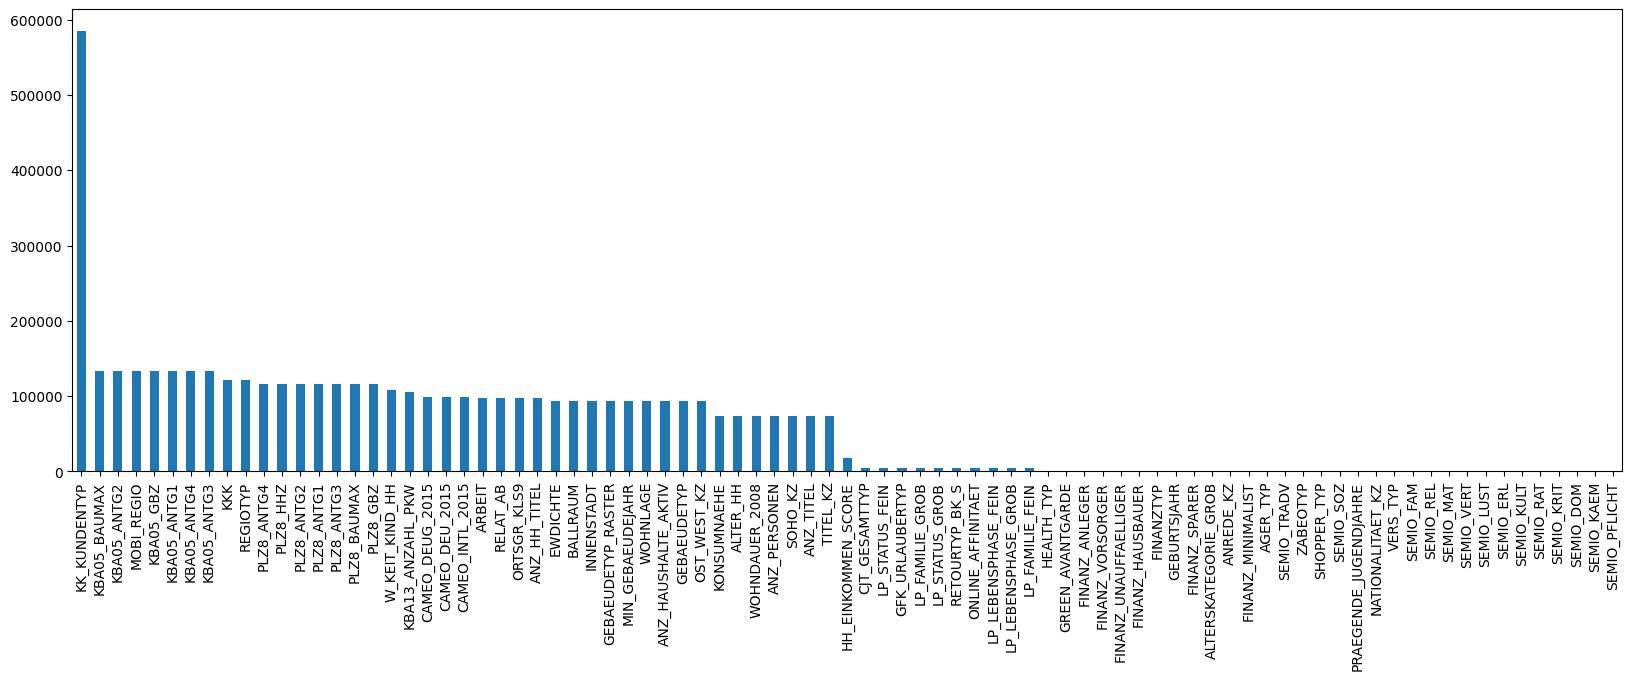

In [ ]:
azdias.isnull().sum().sort_values(ascending=False).plot.bar(figsize=(20,6))

In [ ]:
val = azdias.isnull().sum().sort_values(ascending=False)
print(" features w the top most null values")
val[:15]

 features w the top most null values


,0
KK_KUNDENTYP,584612
KBA05_BAUMAX,133324
KBA05_ANTG2,133324
MOBI_REGIO,133324
KBA05_GBZ,133324
KBA05_ANTG1,133324
KBA05_ANTG4,133324
KBA05_ANTG3,133324
KKK,121196
REGIOTYP,121196



#### step 1.1.1: convert missing value codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object.

Parsing is done to make use of it to identify and clean the data. Data that matches a 'missing' or 'unknown' value code is converted into a numpy NaN value.

In [ ]:
def convert_Nan(df2):
    df = df2.copy(deep=True)

    for row, (col_name, col_values) in enumerate(df.items()):
        NaN_values = feat_info["missing_or_unknown"][row]

        NaN_values = NaN_values.replace(']', '').replace('[', '')
        NaN_values = NaN_values.replace('"', '').split(",")

        NaN_values_clean = []

        if not (len(NaN_values) == 1 and NaN_values[0] == ''):
            for val in NaN_values:
                val = val.strip()
                if val in ['X', 'XX']:
                    NaN_values_clean.append(val)
                else:
                    try:
                        NaN_values_clean.append(int(val))
                    except ValueError:
                        pass

            df[col_name] = df[col_name].replace(NaN_values_clean, np.nan)
    return df

In [ ]:
azdias = convert_Nan(azdias)

In [ ]:
no_of_null_initial = azdias.isnull().sum().sum()
print("null: ", no_of_null_initial)

null:  8373929


#### step 1.1.2: assess missing data in each column

Assess how much missing data and outliers present in each column.

In [ ]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1: '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)

    return mis_val_table_ren_columns

In [ ]:
missingVal = missing_values_table(azdias)
outlier = missingVal['% of Total Values'].sort_values(ascending=False)

In [ ]:
# performing an assessment of how much missing data there is in each column of dataset
print("top 15 features with outliers")
outlier[:15]

top 15 features with outliers


,% of Total Values
TITEL_KZ,99.8
AGER_TYP,77.0
KK_KUNDENTYP,65.6
KBA05_BAUMAX,53.5
GEBURTSJAHR,44.0
ALTER_HH,34.8
KKK,17.7
REGIOTYP,17.7
W_KEIT_KIND_HH,16.6
KBA05_ANTG1,15.0


array([<Axes: title={'center': '% of Total Values'}>], dtype=object)

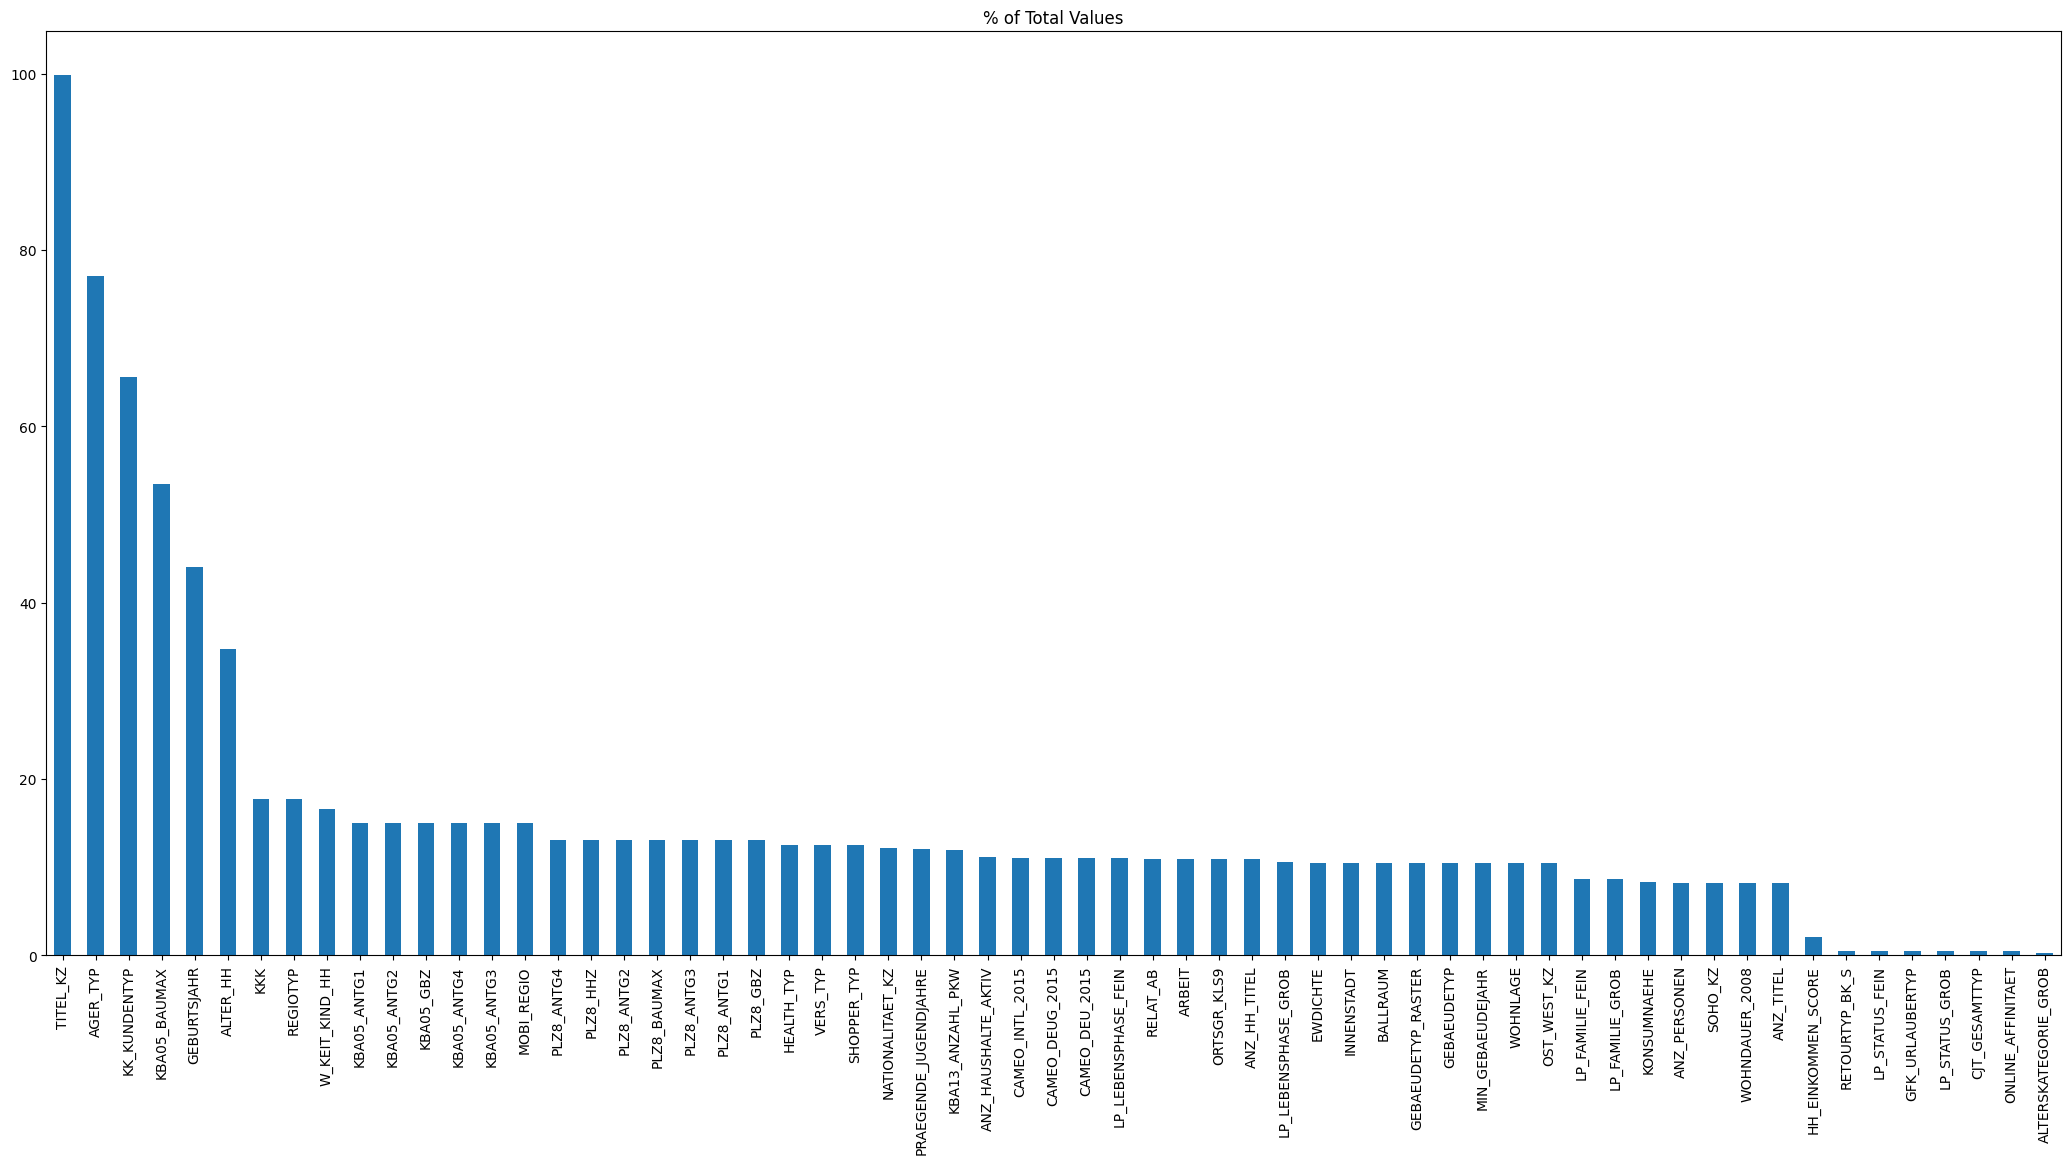

In [ ]:
# investigating patterns in the amount of missing data in each column
missingVal['% of Total Values'].plot.bar(subplots=True, figsize=(26, 12))

<b>The top 5 most significant features with outliers included the following: </b>
    
TITEL_KZ - Academic title flag         <br>
AGER_TYP     - Best-ager typology    <br>
KK_KUNDENTYP  - Consumer pattern over past 12 months   <br>
KBA05_BAUMAX  - Most common building type within the microcell   <br>
GEBURTSJAHR   - Year of birth   <br>
<hr>

In [ ]:
# removing the outlier columns from dataset
outliers = outlier.keys().tolist()
for i in outliers[:6]:
    print("dropping feature: ", i)
    azdias.drop(columns=i, inplace= True)

dropping feature:  TITEL_KZ
dropping feature:  AGER_TYP
dropping feature:  KK_KUNDENTYP
dropping feature:  KBA05_BAUMAX
dropping feature:  GEBURTSJAHR
dropping feature:  ALTER_HH


In [ ]:
no_of_null_after = azdias.isnull().sum().sum()
print("null values before: ", no_of_null_initial)
print("null values after: ", no_of_null_after)
print("difference: ", no_of_null_initial - no_of_null_after)

null values before:  8373929
null values after:  5035304
difference:  3338625


array([<Axes: title={'center': '% of Total Values'}>], dtype=object)

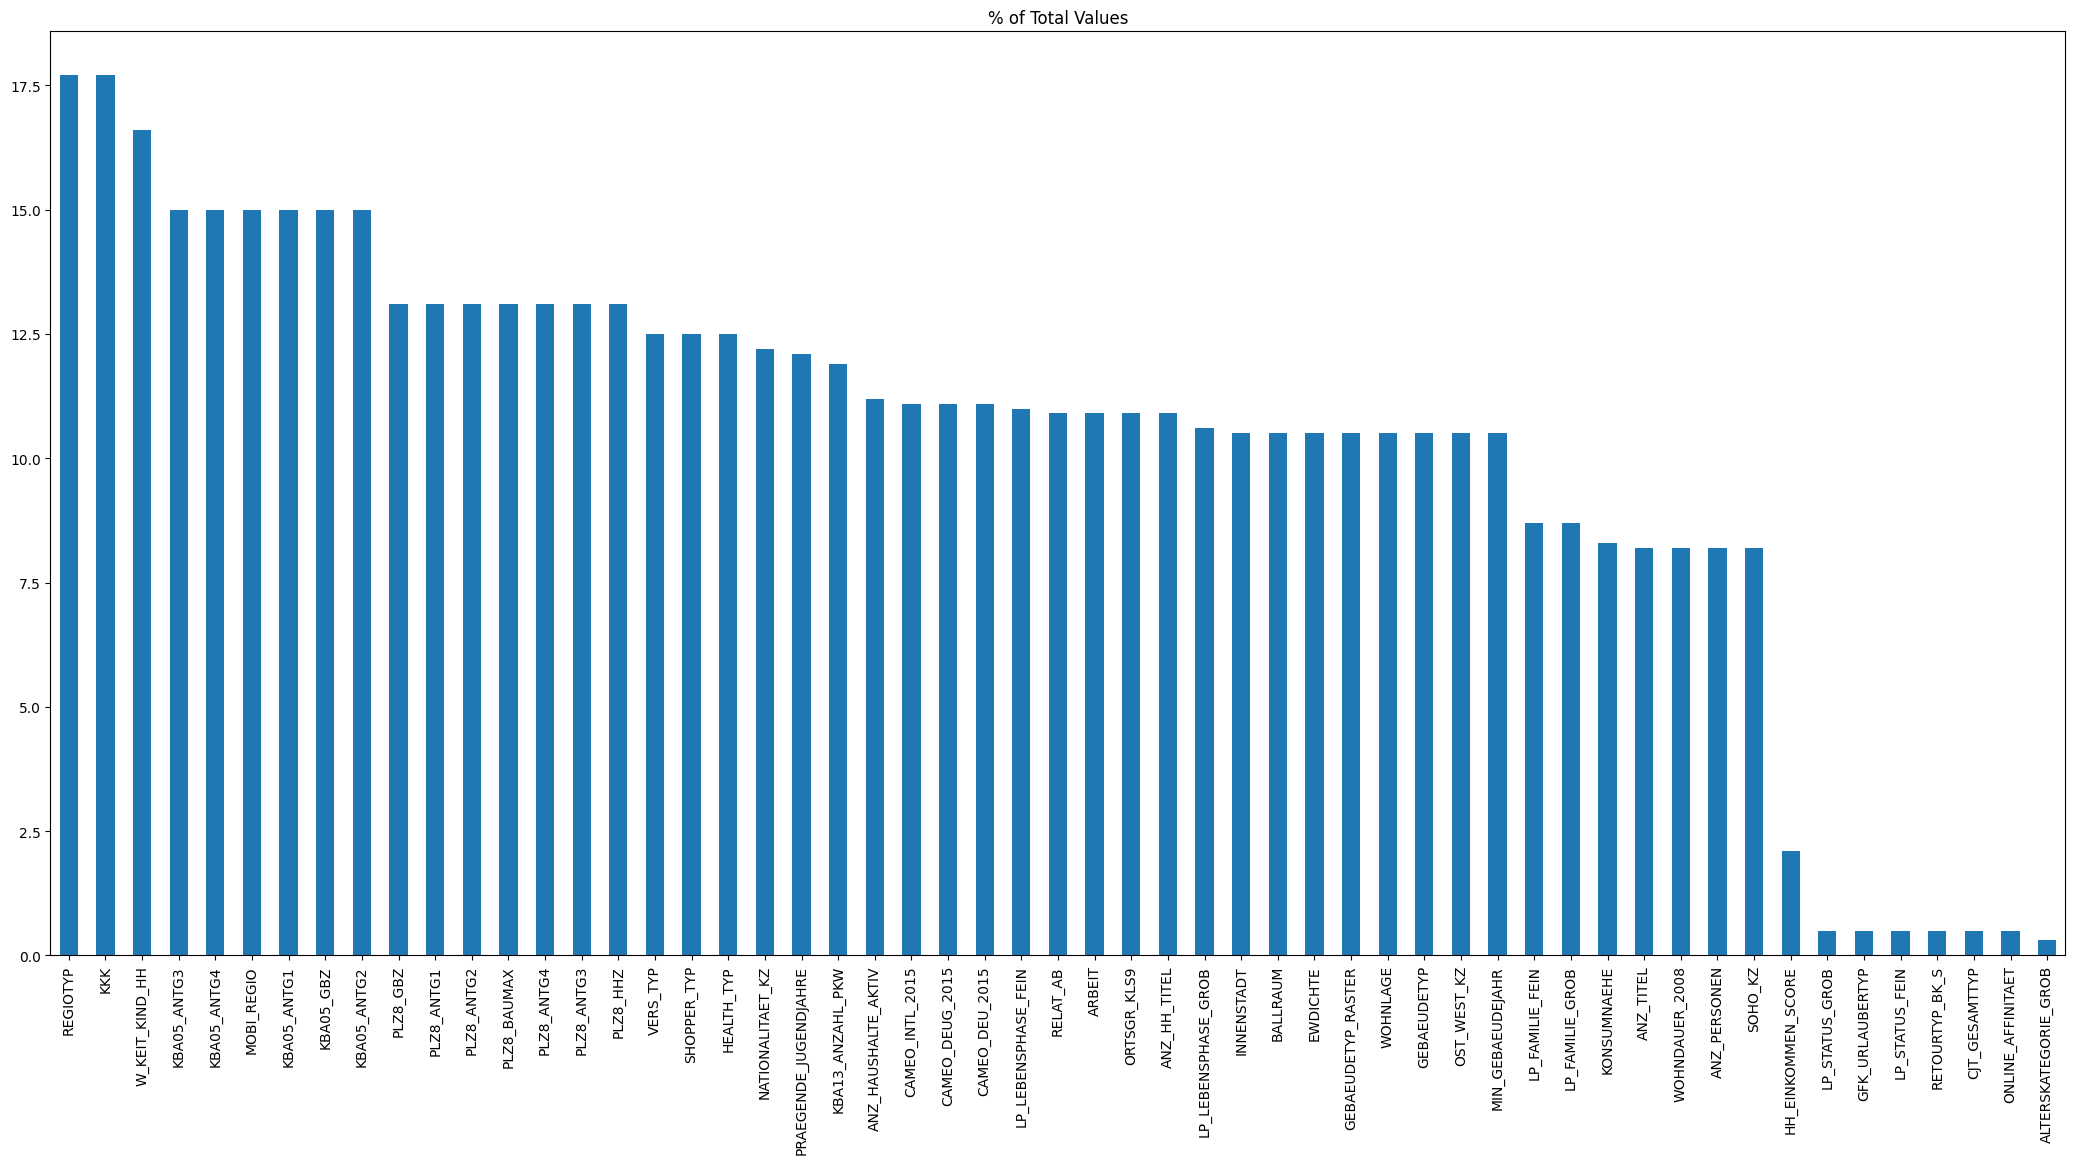

In [ ]:
missingVal_aft = missing_values_table(azdias)
missingVal_aft['% of Total Values'].plot.bar(subplots=True, figsize=(26, 12))

### Analysis

<h3> The top 6 most significant features with outliers included the following: </h3>
<hr>
TITEL_KZ - Academic title flag         <br>
AGER_TYP     - Best-ager typology    <br>
KK_KUNDENTYP  - Consumer pattern over past 12 months   <br>
KBA05_BAUMAX  - Most common building type within the microcell   <br>
GEBURTSJAHR   -  Year of birth <br>
ALTER_HH - Birthdate of head of household <br>
<hr>

 I cannot seem to find any relation with these values. TITEL_KZ had the highest number of missing values with more than 90% however its removal would hardly affect the data and clustering algorithm as an individuals title would hardly be a determing feature in this dataset.

 'KK_KUNDENTYP' ,'GEBURTSJAHR' features consist of information regarding years of birth while the remaining feature which possibly might have been usefull is the consumer pattern over the last 12 months
<hr>

 The top 6 most significant features with least outliers included the following:

REGIOTYP -  Neighborhood typology          <br>
KKK  -  Purchasing power in region              <br>
W_KEIT_KIND_HH  -  Likelihood of children in household     <br>
KBA05_ANTG1   -  Number of 1-2 family houses in the microcell      <br>
MOBI_REGIO - Movement patterns   <br>
KBA05_GBZ - Number of buildings in the microcell

 These features might prove useful in data analysis since these features describe the econmic and social aspects of the demography. Purchasing power, movement patterns and number of buildings and neighbour describe an individuals/socities collective wealth while the strength of family members (childen, dependents) determines a families purchasing and economical needs.

<hr>

#### step 1.1.3: assess missing data in each row

1. Assess missing data in each row
2. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.
3. Make observations regarding the results

In [ ]:
# how much data is missing in each row of the dataset
missing_row = azdias.isnull().sum(axis=1).count()
missing_row

np.int64(891221)

In [ ]:
# averaging value, can be used fo separating rows ahead
azdias.isnull().sum(axis=1).mean()

np.float64(5.649893797385833)

In [ ]:
low_values = azdias[azdias.isnull().sum(axis=1) < azdias.isnull().sum(axis=1).mean()].copy()
high_values = azdias[azdias.isnull().sum(axis=1) >= azdias.isnull().sum(axis=1).mean()].copy()

In [ ]:
low_values.info()

<class 'pandas.core.frame.DataFrame'>
Index: 719624 entries, 1 to 891220
Data columns (total 79 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   718093 non-null  float64
 1   ANREDE_KZ              719624 non-null  int64  
 2   CJT_GESAMTTYP          719624 non-null  float64
 3   FINANZ_MINIMALIST      719624 non-null  int64  
 4   FINANZ_SPARER          719624 non-null  int64  
 5   FINANZ_VORSORGER       719624 non-null  int64  
 6   FINANZ_ANLEGER         719624 non-null  int64  
 7   FINANZ_UNAUFFAELLIGER  719624 non-null  int64  
 8   FINANZ_HAUSBAUER       719624 non-null  int64  
 9   FINANZTYP              719624 non-null  int64  
 10  GFK_URLAUBERTYP        719624 non-null  float64
 11  GREEN_AVANTGARDE       719624 non-null  int64  
 12  HEALTH_TYP             704814 non-null  float64
 13  LP_LEBENSPHASE_FEIN    699921 non-null  float64
 14  LP_LEBENSPHASE_GROB    700048 non-null  f

<Axes: xlabel='None', ylabel='count'>

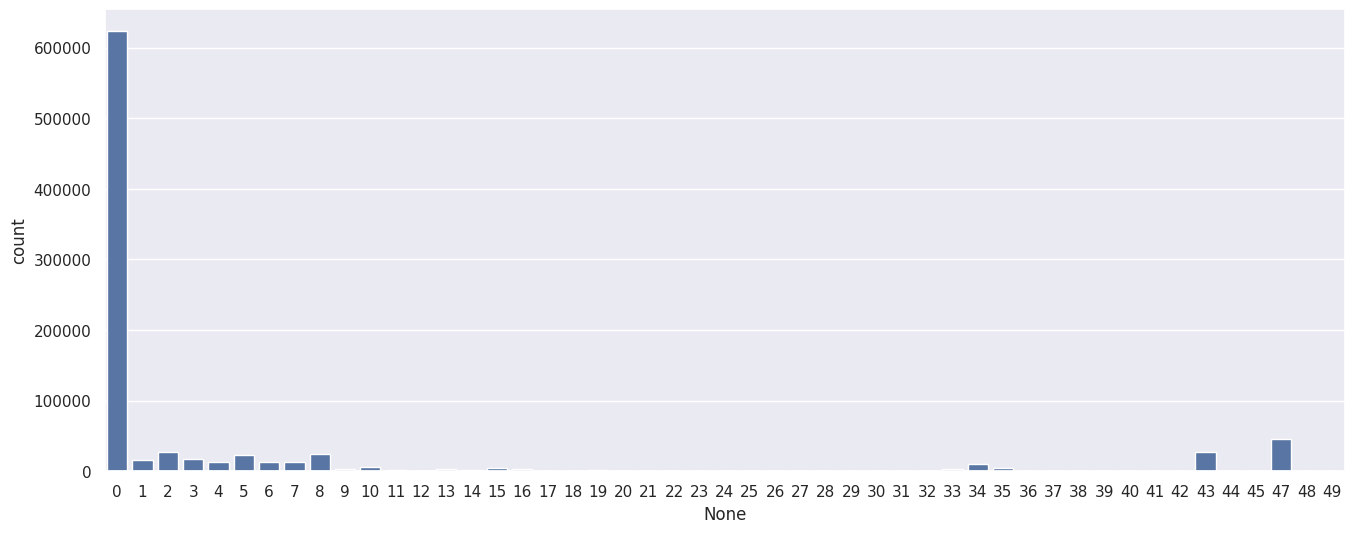

In [ ]:
# dividing the data into two subsets based on the number of mussing values in each row
missing_counts = azdias.isnull().sum(axis=1)
filtered = missing_counts[missing_counts < 50]
sns.set(rc={'figure.figsize': (16, 6)})
sns.countplot(x=filtered)

#### assessing quality of data. create subsets

In [ ]:
low_values = azdias[azdias.isnull().sum(axis=1) < azdias.isnull().sum(axis=1).mean()].copy()
high_values = azdias[azdias.isnull().sum(axis = 1) >= azdias.isnull().sum(axis = 1).mean()].copy()

In [ ]:
low_values1 = missing_values_table(low_values)
low_values1[:10]

,Missing Values,% of Total Values
W_KEIT_KIND_HH,39782,5.5
REGIOTYP,38742,5.4
KKK,38742,5.4
LP_LEBENSPHASE_FEIN,19703,2.7
LP_LEBENSPHASE_GROB,19576,2.7
LP_FAMILIE_GROB,19575,2.7
LP_FAMILIE_FEIN,19575,2.7
SHOPPER_TYP,14810,2.1
HEALTH_TYP,14810,2.1
VERS_TYP,14810,2.1


In [ ]:
high_values1 = missing_values_table(high_values)
high_values1.tail(20)

,Missing Values,% of Total Values
WOHNLAGE,93148,54.3
MIN_GEBAEUDEJAHR,93148,54.3
OST_WEST_KZ,93148,54.3
LP_LEBENSPHASE_FEIN,77929,45.4
LP_LEBENSPHASE_GROB,74996,43.7
KONSUMNAEHE,73925,43.1
SOHO_KZ,73499,42.8
ANZ_PERSONEN,73499,42.8
ANZ_TITEL,73499,42.8
WOHNDAUER_2008,73499,42.8


In [ ]:
low_values1[1:10]

,Missing Values,% of Total Values
REGIOTYP,38742,5.4
KKK,38742,5.4
LP_LEBENSPHASE_FEIN,19703,2.7
LP_LEBENSPHASE_GROB,19576,2.7
LP_FAMILIE_GROB,19575,2.7
LP_FAMILIE_FEIN,19575,2.7
SHOPPER_TYP,14810,2.1
HEALTH_TYP,14810,2.1
VERS_TYP,14810,2.1


### comparing the sliced datasets

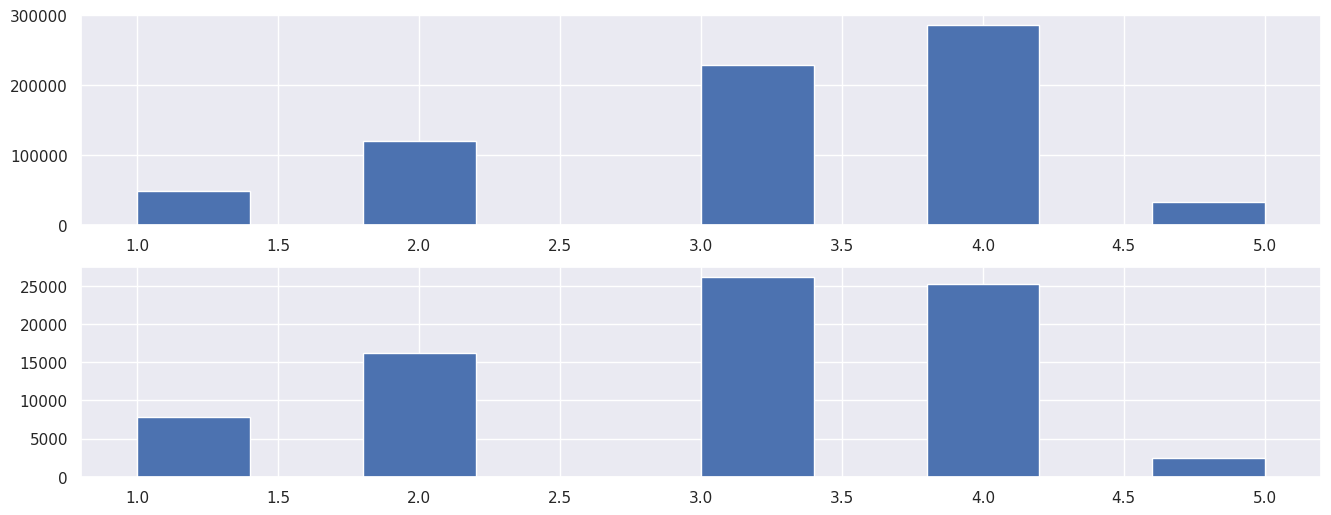

In [ ]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(211)
ax1.hist(low_values['ARBEIT'].dropna())
ax2 = fig1.add_subplot(212)
ax2.hist(high_values['ARBEIT'].dropna())

plt.show()

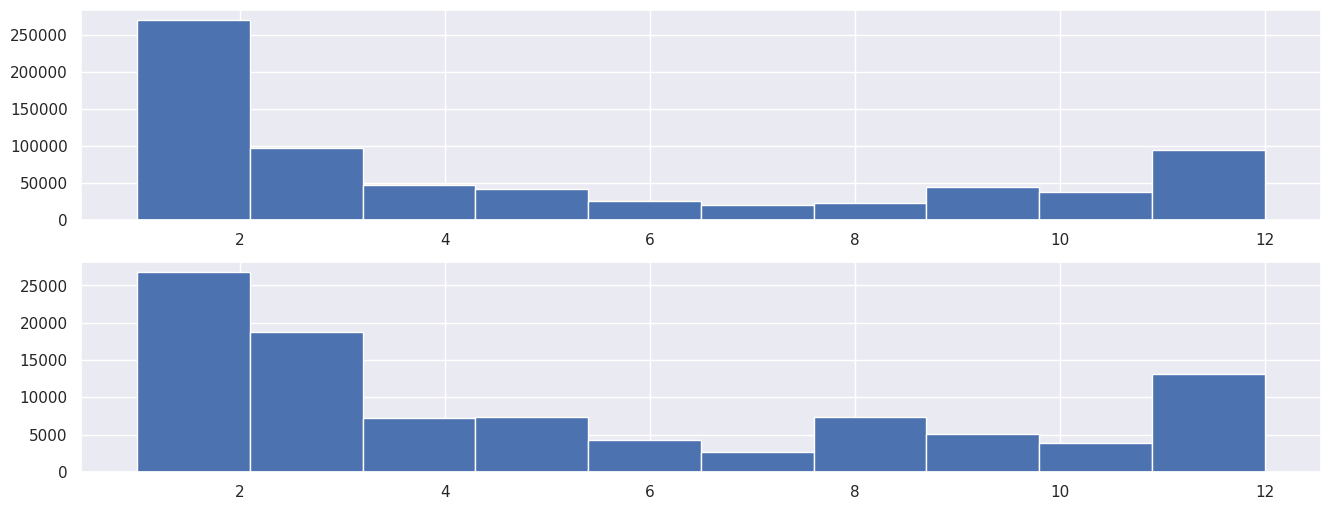

In [ ]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(211)
ax1.hist(low_values['LP_LEBENSPHASE_GROB'].dropna())
ax2 = fig1.add_subplot(212)
ax2.hist(high_values['LP_LEBENSPHASE_GROB'].dropna())

plt.show()

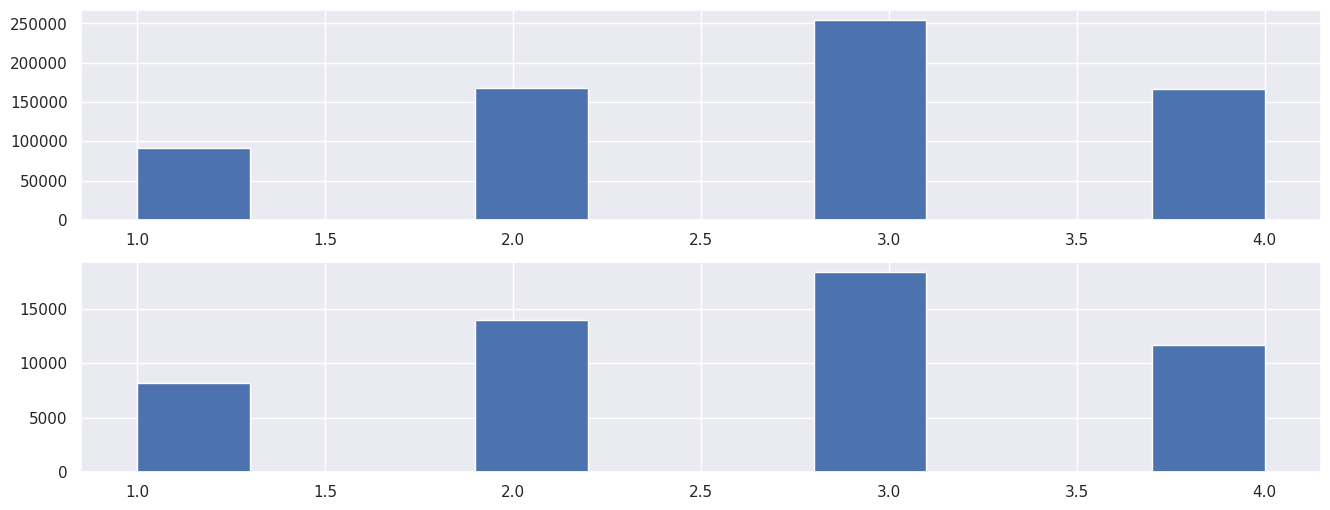

In [ ]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(211)
ax1.hist(low_values['KKK'].dropna())
ax2 = fig1.add_subplot(212)
ax2.hist(high_values['KKK'].dropna())

plt.show()

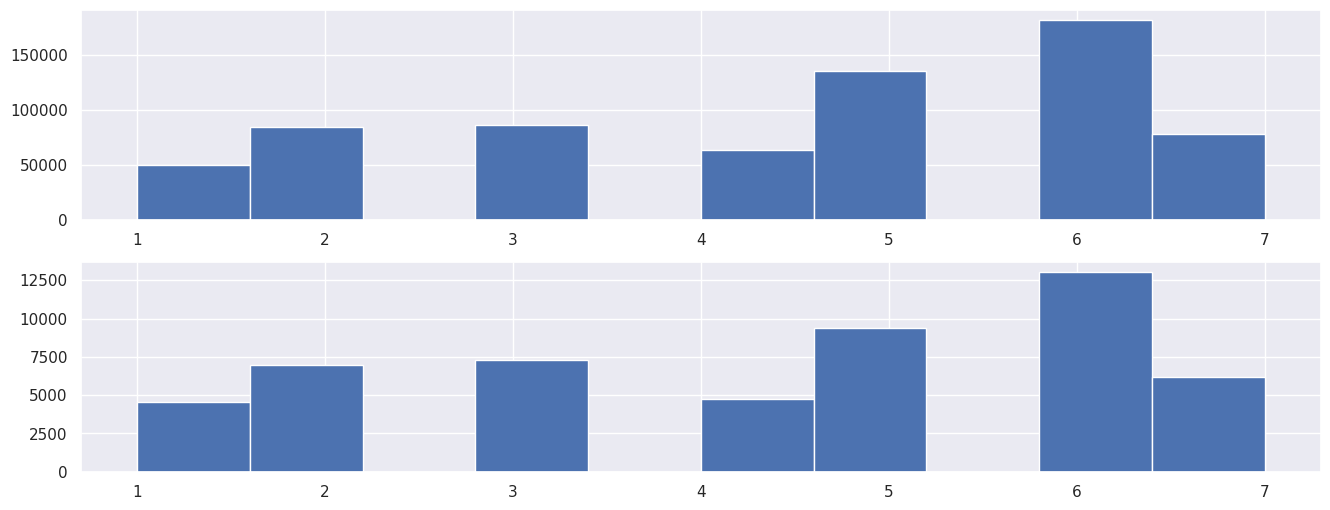

In [ ]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(211)
ax1.hist(low_values['REGIOTYP'].dropna())
ax2 = fig1.add_subplot(212)
ax2.hist(high_values['REGIOTYP'].dropna())

plt.show()

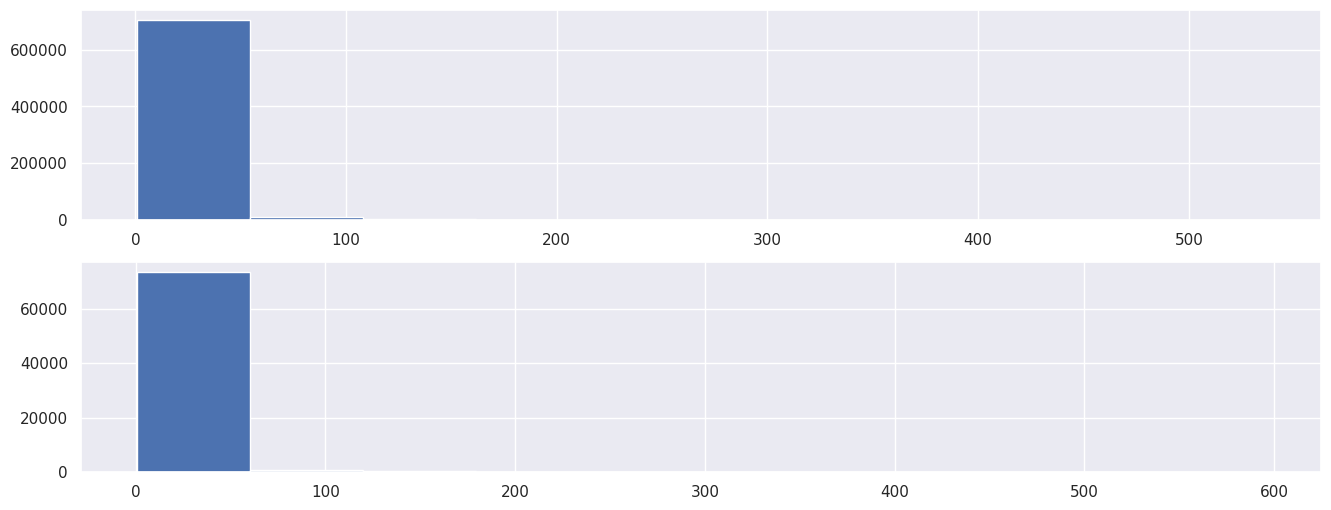

In [ ]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(211)
ax1.hist(low_values['ANZ_HAUSHALTE_AKTIV'].dropna())
ax2 = fig1.add_subplot(212)
ax2.hist(high_values['ANZ_HAUSHALTE_AKTIV'].dropna())

plt.show()

#### discussion 1.1.3: assessing the missing data in each row


The data shows that the number of missing values in the rows are negligable as removing the rows which contain missing values won't make much of a diffence to the shape/distribution of the entire dataset. The comparision between the histograms of the features which have the lowest number of missing values shows exactly this that the general shape of the graph/distrubtion remains the same between the data which contains greater missing values and the data which contains lesser NaN values.

Criterion for seperation of the day was the mean of the sum of the number of null values
<hr>

#### step 1.2: select and re-encode features


- For numeric and interval data, these features will be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling is done for the remaining two variable types: categorical, and 'mixed'.

In [ ]:
# saving data to save computation
azdias.to_csv('data-edited.csv', sep=';')

In [ ]:
feat_info.head(4)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]


In [ ]:
feat_info['type'].value_counts()

,count
type,
ordinal,49
categorical,21
numeric,7
mixed,7
interval,1


#### step 1.2.1: re-encode categorical features

processing categorical data

In [ ]:
# assessing categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
categorical_val = feat_info[feat_info['type'] == 'categorical']

In [ ]:
categorical_val_cols = categorical_val['attribute'].tolist()

In [ ]:
categorical_val_cols

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [ ]:
type(azdias)

pandas.core.frame.DataFrame

In [ ]:
# find number of classes of categorical data

In [ ]:
categorical_data = pd.DataFrame(columns=['category', 'number'])

for i in categorical_val_cols:
    if i in azdias:
        c = pd.DataFrame([{'category': i, 'number': int(azdias[i].nunique())}])
        categorical_data = pd.concat([categorical_data, c], ignore_index=True)

        # print(i, azdias[i].nunique())

In [ ]:
categorical_data

,category,number
0,ANREDE_KZ,2
1,CJT_GESAMTTYP,6
2,FINANZTYP,6
3,GFK_URLAUBERTYP,12
4,GREEN_AVANTGARDE,2
5,LP_FAMILIE_FEIN,11
6,LP_FAMILIE_GROB,5
7,LP_STATUS_FEIN,10
8,LP_STATUS_GROB,5
9,NATIONALITAET_KZ,3


In [ ]:
categorical_data.columns

Index(['category', 'number'], dtype='object')

In [ ]:
categorical_data = categorical_data[categorical_data['number'] > 2]

In [ ]:
categorical_data

,category,number
1,CJT_GESAMTTYP,6
2,FINANZTYP,6
3,GFK_URLAUBERTYP,12
5,LP_FAMILIE_FEIN,11
6,LP_FAMILIE_GROB,5
7,LP_STATUS_FEIN,10
8,LP_STATUS_GROB,5
9,NATIONALITAET_KZ,3
10,SHOPPER_TYP,4
13,ZABEOTYP,6


In [ ]:
categorical_val_cols_morethan2 = categorical_data['category']

In [ ]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [ ]:
categorical_val_cols_morethan2

,category
1,CJT_GESAMTTYP
2,FINANZTYP
3,GFK_URLAUBERTYP
5,LP_FAMILIE_FEIN
6,LP_FAMILIE_GROB
7,LP_STATUS_FEIN
8,LP_STATUS_GROB
9,NATIONALITAET_KZ
10,SHOPPER_TYP
13,ZABEOTYP


#### I have decided to remove categorical data with more than 2 variables as I want to keep the data as simple as possible without adding more complexity to it. Only the required categorical features mentioned ahead on which one-hot encoding will be applied shall be used.

In [ ]:
for i in categorical_val_cols_morethan2:
    if(i in azdias.columns):
        azdias.drop(columns=i, inplace=True)

In [ ]:
mixed_val = feat_info[ feat_info['type'] == 'mixed']

In [ ]:
mixed_val

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [ ]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### discussion 1.2.1: re-encode categorical features

Have largely removed categorical variables with more than two features int them. The data already has much dimensions and adding more and investing energy at this time doesn't seem prudent. If the PCA doesn't yield a good accuracy/prediction later than we shall reconsider our decision and think about adding more classes either by engineering or by not dropping these columns.

In [ ]:
azdias.to_csv('data-edited-2.csv', sep=';')

#### step 1.2.2: engineer mixed-type features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention.
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west).
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage.


In [ ]:
mixed_val_col = mixed_val['attribute'].tolist()

In [ ]:
azdias = pd.read_csv('data-edited-2.csv', sep=';')

In [ ]:
mixed_val = feat_info[feat_info['type'] == 'mixed']

In [ ]:
df = azdias.copy()
# one hot encoding: categorical value feature separation
df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]), 'MAINSTREAM'] = 1
df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]), 'MAINSTREAM'] = 0

# WESTGERMANY, The OST_WEST_KZ feature could be used instead for seperation. 1= True. 0= False
df.loc[df['OST_WEST_KZ']=='W','WESTGERMANY']=1
df.loc[df['OST_WEST_KZ']=='O','WESTGERMANY']=0

# manually separating
df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,2]),'GENERATION']=1
df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([3,4]),'GENERATION']=2
df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]),'GENERATION']=3
df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([8,9]),'GENERATION']=4
df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]),'GENERATION']=5
df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([14,15]),'GENERATION']=6

#dropping the initial column
df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
df.drop('OST_WEST_KZ', axis=1, inplace=True)

#investigating "CAMEO_INTL_2015" and engineering new variables
df.loc[df['CAMEO_INTL_2015'].isin(['11','12','13','14','15']),'HOUSEHOLD']=1
df.loc[df['CAMEO_INTL_2015'].isin(['21','22','23','24','25']),'HOUSEHOLD']=2
df.loc[df['CAMEO_INTL_2015'].isin(['31','32','33','34','35']),'HOUSEHOLD']=3
df.loc[df['CAMEO_INTL_2015'].isin(['41','42','43','44','45']),'HOUSEHOLD']=4
df.loc[df['CAMEO_INTL_2015'].isin(['51','52','53','54','55']),'HOUSEHOLD']=5
df.loc[df['CAMEO_INTL_2015'].isin(['11','21','31','41','51']),'LIFESTYLE']=1
df.loc[df['CAMEO_INTL_2015'].isin(['12','22','32','42','52']),'LIFESTYLE']=2
df.loc[df['CAMEO_INTL_2015'].isin(['13','23','33','43','53']),'LIFESTYLE']=3
df.loc[df['CAMEO_INTL_2015'].isin(['14','24','34','44','54']),'LIFESTYLE']=4
df.loc[df['CAMEO_INTL_2015'].isin(['15','25','35','45','55']),'LIFESTYLE']=5
df.drop('CAMEO_INTL_2015', axis = 1, inplace=True)

In [ ]:
# dropping remaining mixed values columns
for i in mixed_val_col:
    if(i in azdias.columns):
        azdias.drop(columns=i, inplace= True)

#### checkpoint

Saving and loading here because of heavy RAM use causes python to crash

In [ ]:
azdias.to_csv('data-edited-3.csv', sep=';')

In [ ]:
azdias = pd.read_csv('data-edited-3.csv', sep=';')

#### discussion 1.2.2: engineer mixed-type features

- multi - class categorical classes have been removed. I want to keep this data as simple as possible as creating/imputing more features creates a chance that there might be higher accuracy but would also require higher tuning.
- CAMEO_INTL_2015 &  PRAEGENDE_JUGENDJAHRE have been classified with a speciific number assigned to each of them.


#### step 1.2.3: completing feature selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### step 1.3: create a cleaning function


#### note: This cleaning function neatly encapsulates all the data transformation done beforehand. This is a more easier way to understand the code. This function however does use two functions which are created in the beginning